기본값 : 0  
INFO 로그 필터링 : 1  
WARNING 로그 필터링 : 2  
ERROR 로그 필터링 : 3  

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-12-02 15:32:35.771790: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3590630121869482113
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11669929984
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13325824772541230604
 physical_device_desc: "device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:b3:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [4]:
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'D2Coding'

In [5]:
tf.__version__

'2.10.0'

In [6]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tqdm import tqdm

# 트랜스포머 구현

## 에셋 임베딩 레이어

In [16]:
class SeqAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, window_size, d_model, is_decoder=False, **kwargs):
        super(SeqAndPositionEmbedding, self).__init__(**kwargs)
        self.d_model = d_model
        self.is_decoder = is_decoder
        self.__windowsize = window_size
        
        self.esset_emb = tf.keras.layers.Dense(self.d_model) #입력 데이터 shape : (batch_size, window_size)
        self.pos_emb = tf.keras.layers.Embedding(self.__windowsize, self.d_model)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "__windowsize":self.__windowsize,
            "is_decoder":self.is_decoder,
        })
        return config
    
    def call(self, x):
        L = tf.shape(x)[-1] if self.is_decoder else self.__windowsize
        batch_size = tf.shape(x)[0]
        
        positions = tf.range(start=0, limit= L, delta=1)
        positions = self.pos_emb(positions)
        positions = positions[tf.newaxis,:]
        x_ = tf.reshape(x,(batch_size,L,1))
        x_ = self.esset_emb(x_)
        
        return x_ + positions

## 인코더 레이어

In [17]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    assert d_model%num_heads==0,  f'It is in {name}'
    d_model_each_head = int(d_model/num_heads)
    attention = tf.keras.layers.MultiHeadAttention(num_heads, d_model_each_head, name=f"{name}_MHAtt")(
        query = inputs, value = inputs, #key = inputs
    )

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs+attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention+outputs)

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

In [18]:
def encoder(window_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(window_size,), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = SeqAndPositionEmbedding(window_size,d_model)(inputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f"encoder_layer_{i}",)([outputs])

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

## 셀프 어텐션(Self-attention)과 룩-어헤드 마스크(Look-ahead mask)

In [19]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask(0)하는 함수
def create_look_ahead_mask(inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i >= j, dtype="int32")
    mask = tf.reshape(mask, (1, sequence_length, sequence_length))
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    return tf.tile(mask, mult)

In [20]:
tmp = tf.constant(np.arange(3*5*7).reshape((3,5,7)), dtype=tf.float32)

create_look_ahead_mask(tmp)

<tf.Tensor: shape=(3, 5, 5), dtype=int32, numpy=
array([[[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1]],

       [[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1]],

       [[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1]]], dtype=int32)>

## 디코더 레이어

In [21]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.Input(shape=(None, None), name="look_ahead_mask")

    # 패딩 마스크X

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    assert d_model%num_heads==0,  f'It is in {name}'
    d_model_each_head = int(d_model/num_heads)
    attention1 = tf.keras.layers.MultiHeadAttention(num_heads, d_model_each_head, name=f"{name}_MHAtt_1")(
        query = inputs, value = inputs, attention_mask = look_ahead_mask, #key = inputs
    )

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1+inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = tf.keras.layers.MultiHeadAttention(num_heads, d_model_each_head, name=f"{name}_MHAtt_2")(
        query = attention1, value = enc_outputs, #key = enc_outputs
    )

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2+attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs+attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [22]:
def decoder(forecast_range, num_layers, dff,
            d_model, num_heads, dropout,
            name='transformer_decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    # 포지셔널 인코딩 + 드롭아웃
    embeddings = SeqAndPositionEmbedding(forecast_range,d_model,is_decoder=True)(inputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = create_look_ahead_mask(outputs)
    
    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f'decoder_layer_{i}',)(inputs=[outputs, enc_outputs, look_ahead_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs],
        outputs=outputs,
        name=name)


## 인코더-디코더 어텐션

In [23]:
def attention_enc_dec(window_size,d_model,num_heads,ref_seq_enc_num,name='attention_enc2dec'):
    target_outputs = tf.keras.Input(shape=(window_size,d_model), name="target_outputs")
    ref_outputs = [tf.keras.Input(shape=(window_size,d_model), name=f"ref_outputs_{i}") for i in range(ref_seq_enc_num)]
    
    total_outputs = [target_outputs]
    total_outputs.extend(ref_outputs)
    
    concat_outputs = tf.keras.layers.Concatenate(axis=-1,name = "concat_enc2dec")(total_outputs)
    concat_outputs = tf.keras.layers.Dense(d_model)(concat_outputs)
        
    enc_outputs = tf.keras.layers.MultiHeadAttention(num_heads, d_model, name="multi_head_attention_1")(
        query = concat_outputs, value = concat_outputs, #key = inputs
    )

    return tf.keras.Model(inputs=total_outputs, outputs=enc_outputs, name=name)

In [24]:
enc_dec_att = attention_enc_dec(30,128,8,3)
enc_dec_att.summary()

Model: "attention_enc2dec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target_outputs (InputLayer)    [(None, 30, 128)]    0           []                               
                                                                                                  
 ref_outputs_0 (InputLayer)     [(None, 30, 128)]    0           []                               
                                                                                                  
 ref_outputs_1 (InputLayer)     [(None, 30, 128)]    0           []                               
                                                                                                  
 ref_outputs_2 (InputLayer)     [(None, 30, 128)]    0           []                               
                                                                                  

In [25]:
del enc_dec_att
tf.keras.backend.clear_session()

## 멀티 인풋 트랜스포머

### 시퀀스 어탠션(sequence attention)

In [26]:
class SeqAttention(tf.keras.layers.Layer):
    def __init__(self, num_seq, window_size, d_model, attmap_dropout=0.1, name="sequence_attention"):
        super(SeqAttention, self).__init__(name=name)
        self.num_seq = num_seq
        self.window_size = window_size
        self.d_model = d_model
        self.attmap_dropout = attmap_dropout
        
        #필요 레이어
        ## 어탠션 맵을 만들 레이어
        self.att_concate = tf.keras.layers.Concatenate(axis=1)
        #self.attmap_dense= tf.keras.layers.Dense(self.num_seq*self.d_model)
        self.attmap_dense=tf.keras.Sequential([
            tf.keras.layers.Dense(int(self.num_seq*self.d_model*0.5)),
            tf.keras.layers.Dropout(self.attmap_dropout),
            tf.keras.layers.Dense(self.num_seq*self.d_model)
        ])
        self.att_softmax = tf.keras.layers.Softmax()
        
        #어탠션맵 생성 이후 처리
        
        #(+ 이부분 좀 생각해보자. 어쩌면 d_model 방향으로 차례로 넣는걸 해야할지도?)
        self.concate = tf.keras.layers.Concatenate(axis=2) #d_model 방향으로 concatenate 
        self.dense = tf.keras.layers.Dense(self.d_model, activation=None) #
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_seq":self.num_seq,
            "window_size":self.window_size,
            "d_model": self.d_model,
            "attmap_dropout":self.attmap_dropout,
        })
        return config
    
    
    def call(self,query_,key_):
        '''
        input 모양 : 
            쿼리 -> (None, window_size, d_model, num_seq)
            키/밸류 -> (None, num_seq, window_size)
        
        attention map 모양 : (None, 1, d_model, num_seq)
        
        output 모양:
            (None, window_size, 2 * d_model, num_seq)
        '''
        
        #Attention map 만들기
        min_seq = tf.math.reduce_min(key_,axis=1) #(None, window_size)
        avg_seq = tf.math.reduce_mean(key_,axis=1) #(None, window_size)
        max_seq = tf.math.reduce_max(key_,axis=1) #(None, window_size)
        
        att_input = self.att_concate([min_seq,avg_seq,max_seq]) #(None, 3 * window_size)
        att_score = self.attmap_dense(att_input) #(None, d_model * num_seq)
        att_map = self.att_softmax(att_score)
        att_map = tf.reshape(att_map,[-1,1,self.d_model,self.num_seq]) #(None, 1, d_model, num_seq)
        
        #Attention
        att_out = tf.math.multiply(query_, att_map)
        
        #쿼리와의 concatenate
        concat_query = self.concate([query_, att_out]) #(None, window_size, 2*d_model, num_seq)
        
        #(None, window_size, 2*d_model, num_seq) -> (None, window_size, d_model, num_seq)
        concat_query = tf.transpose(concat_query,[0,1,3,2])
        concat_query = tf.reshape(concat_query,[-1,2*self.d_model])
        out = self.dense(concat_query)
        out = tf.reshape(out,[-1,self.window_size,self.num_seq,self.d_model])
        out = tf.transpose(out,[0,1,3,2])
        
        return out

### 멀티 인풋 트랜스포머

In [27]:
def multi_input_transformer(num_seq,window_size,num_layers,dff,d_model,num_heads,dropout,name=None):
    inputs = tf.keras.Input(shape=(num_seq,window_size), name="inputs")
    
    inputs_split = tf.split(inputs, num_or_size_splits=num_seq, axis=1)
    for i in range(num_seq):
        inputs_split[i] = tf.reshape(inputs_split[i],(-1,window_size))
    
    siamese_enc = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                              d_model=d_model, num_heads=num_heads, dropout=dropout,name = "siamese_encoder")
    
    outputs_concat = []
    for i in range(num_seq):
        #siamese 구조
        outputs = siamese_enc(inputs=[inputs_split[i]])
        #outputs의 shape = (None,window_size,d_model)
        outputs = tf.reshape(outputs,(-1,window_size,d_model,1))
        
        outputs_concat.append(outputs)
    outputs_concat = tf.keras.layers.Concatenate(axis=3,name = "concatenate")(outputs_concat)
    
    outputs_concat_att = SeqAttention(num_seq=num_seq,
                                      window_size=window_size,
                                      d_model=d_model,
                                      attmap_dropout=0.1,
                                      name="sequence_attention")(query_ = outputs_concat, key_=inputs)
    
    reduce_mean_outputs = tf.math.reduce_mean(outputs_concat_att,axis=3)#어탠션 수행 예정!
    return tf.keras.Model(inputs=[inputs], outputs=reduce_mean_outputs, name=name)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


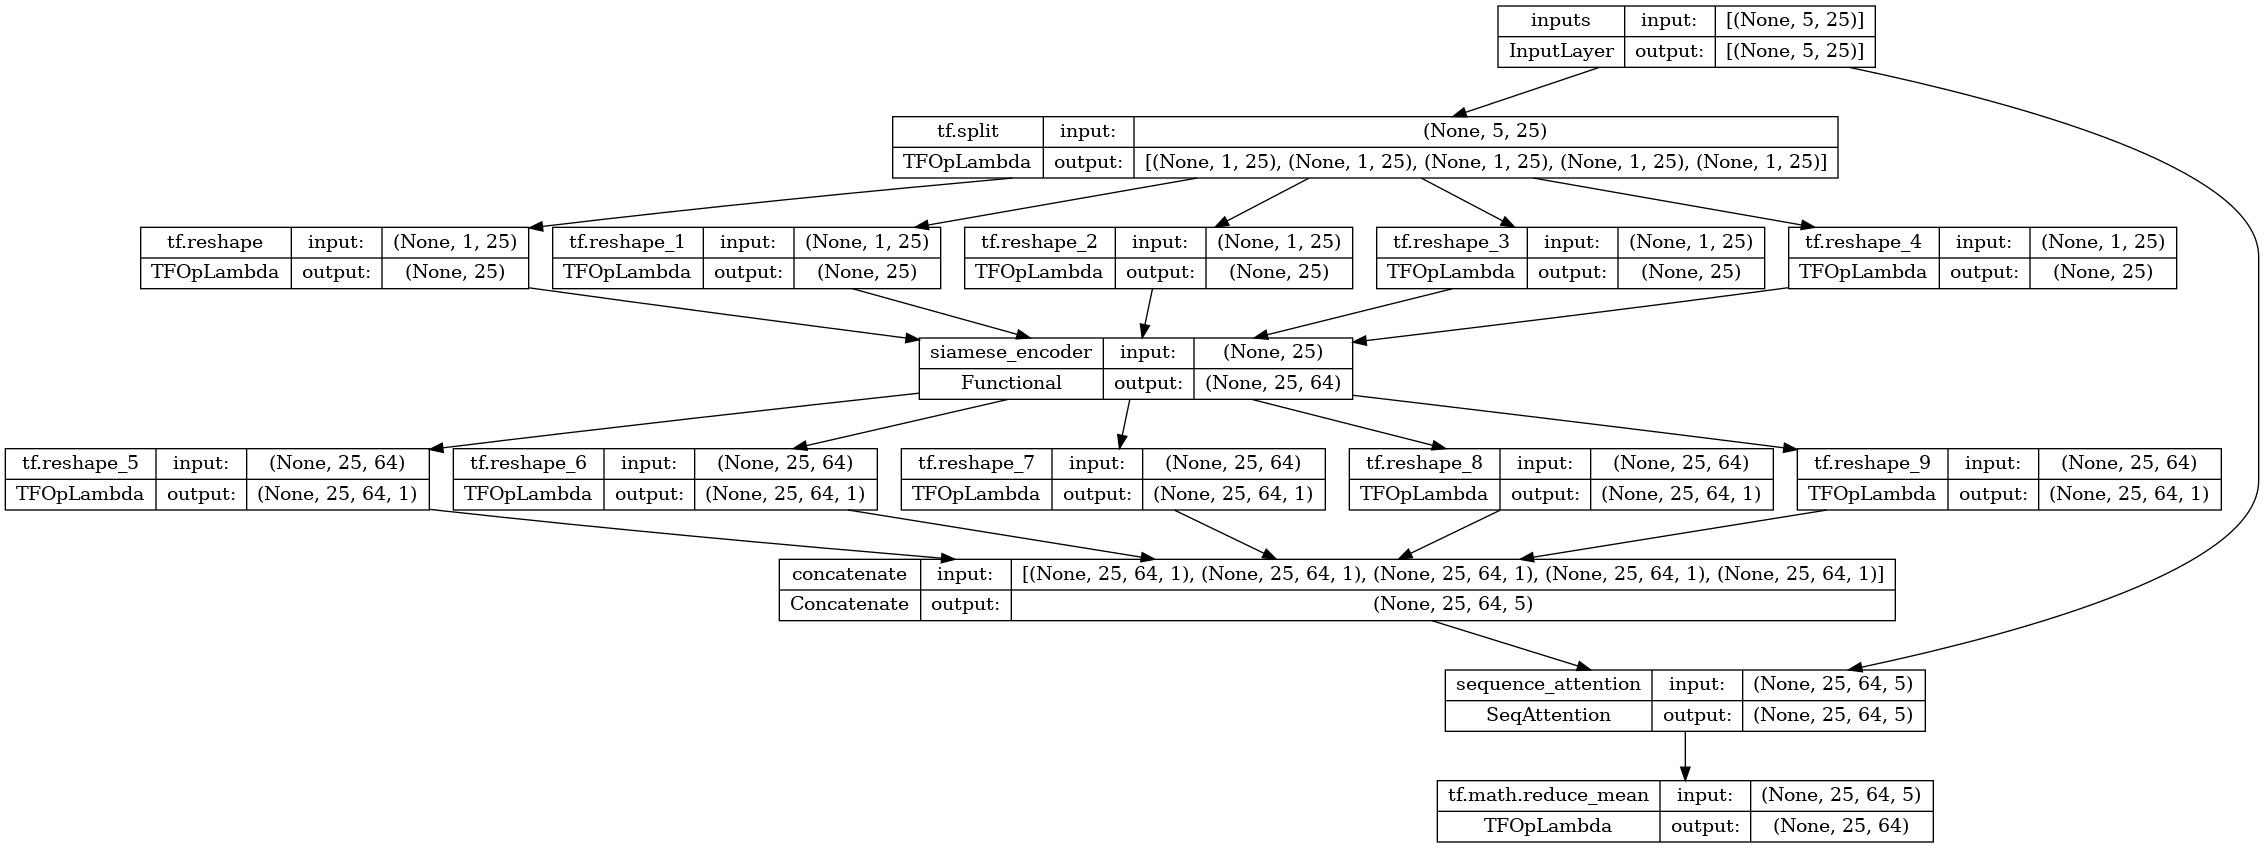

In [28]:
tf.keras.backend.clear_session()

multi_inputs = multi_input_transformer(num_seq = 5,
                                       window_size=25,
                                       num_layers=4,
                                       dff=128,
                                       d_model=64,
                                       num_heads=8,
                                       dropout=0.1,
                                       name='multi_input_transformer')
tf.keras.utils.plot_model(multi_inputs, to_file='./imgs/multi_inputs_transformer.png', show_shapes=True)

In [29]:
del multi_inputs
tf.keras.backend.clear_session()

## MEaI 트랜스포머

In [30]:
def MEaI_transformer(window_size, forecast_range, ref_num_list:list, num_layers, dff,
                     d_model, num_heads, dropout,ref_encoder_name=None,
                     name="MEaI_transformer"):
    
    assert len(ref_num_list) > 0
    assert 0 not in ref_num_list
    assert (ref_encoder_name is None) or type(ref_encoder_name) == list
    if type(ref_encoder_name) == list:
        assert len(ref_encoder_name) == len(ref_num_list)

    # 목표 시퀀스 인코더의 입력
    target_inputs = tf.keras.Input(shape=(window_size,), name="target_inputs")
    
    # 참조 시퀀스 인코더의 입력
    ref_inputs = []
    for idx,s in enumerate(ref_num_list):
        ref_in = tf.keras.Input(shape=(s,window_size), name=f"ref_inputs_{idx}")
        ref_inputs.append(ref_in)
    
    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    #목표 시퀀스 인코더
    Target_seq_outputs = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,name = "Target_seq_encoder")(inputs=[target_inputs])
    
    
    #참조 시퀀스 멀티 인풋 인코더
    ref_seq_outputs = []
    
    if ref_encoder_name is None:
        for idx, s in enumerate(ref_num_list):
            ref_seq = multi_input_transformer(num_seq=s,window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,name=f"ref_seq_encoder_{idx}")(inputs=[ref_inputs[idx]])
            ref_seq_outputs.append(ref_seq)
    else:
        for idx, s in enumerate(ref_num_list):
            ref_seq = multi_input_transformer(num_seq=s,window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,name=ref_encoder_name[idx])(inputs=[ref_inputs[idx]])
            ref_seq_outputs.append(ref_seq)
    
    #concatenate-attention
    total_encode_output = [Target_seq_outputs]
    total_encode_output.extend(ref_seq_outputs)
    
    enc_outputs = attention_enc_dec(window_size,d_model,num_heads,len(ref_num_list),name='attention_enc2dec')(inputs=total_encode_output)
    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    
    dec_outputs = decoder(forecast_range=forecast_range, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,)(inputs=[dec_inputs, enc_outputs])

    # 다음 예측을 위한 출력층
    dec_outputs = tf.keras.layers.Dense(units=d_model//2, activation='relu', name="outputs_dense_1")(dec_outputs)
    dec_outputs = tf.keras.layers.Dense(units=d_model//4, name="outputs_dense_2")(dec_outputs)
    dec_outputs = tf.keras.layers.Dense(units=d_model//8, activation='relu', name="outputs_dense_3")(dec_outputs)
    outputs = tf.keras.layers.Dense(units=1, name="outputs")(dec_outputs)
    
    total_inputs=[target_inputs]
    total_inputs.extend(ref_inputs)
    total_inputs.append(dec_inputs)
    
    return tf.keras.Model(inputs=total_inputs, outputs=outputs, name=name)

# 기본 모델 구조

In [22]:
params = {
    'window_size':30,
    'forecast_range':24,
    'num_layers':4,
    'dff':256,
    'd_model':128,
    'num_heads':4,
    'dropout':0.1
}

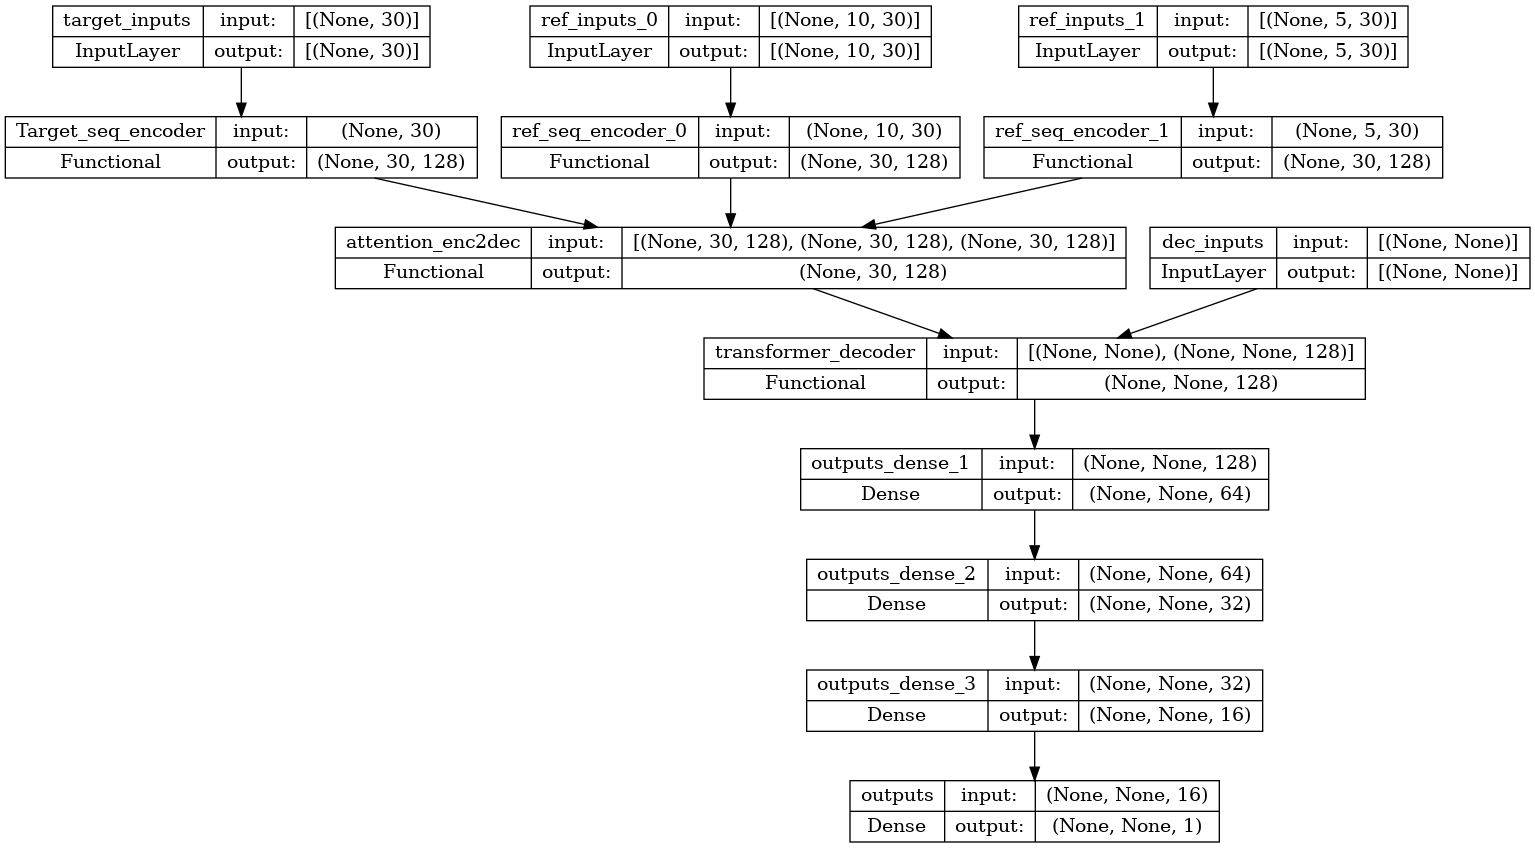

In [23]:
tf.keras.backend.clear_session()

model = MEaI_transformer(
    window_size = params['window_size'],
    forecast_range = params['forecast_range'],
    ref_num_list = [10,5],
    num_layers = params['num_layers'],
    dff = params['dff'],
    d_model = params['d_model'],
    num_heads = params['num_heads'],
    dropout = params['dropout'],
    ref_encoder_name=None,
    name="MEaI_transformer")

tf.keras.utils.plot_model(model, to_file='./imgs/MEaI_transformer.png', show_shapes=True)


# 데이터 생성 & 학습

## PM10

### 데이터 처리

In [ ]:
params_pm10 = {
    'window_size':50,
    'forecast_range':24,
    'num_layers':6,
    'dff':512,
    'd_model':256,
    'num_heads':8,
    'dropout':0.1
}

In [ ]:
PM10 = pd.read_csv('./data/weather_and_pm10.csv')
PM10.일시 = pd.DatetimeIndex(PM10.일시,freq='H')

PM10.index = PM10.일시
PM10 = PM10.drop(columns = ['일시','풍향'])

PM10_col = PM10.columns.copy()
PM10_index = PM10.index.copy()

scaler_pm10 = StandardScaler()
scaler_pm10.fit(PM10)
PM10 = scaler_pm10.transform(PM10)
#PM10[['기압','시정']] = PM10[['기압','시정']]*0.01

PM10 = pd.DataFrame(PM10,columns = PM10_col,index=PM10_index)

PM10

In [ ]:
plt.figure(figsize=(10,8))

sns.heatmap(PM10.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
seoul_pm10 = PM10['서울pm10'].to_numpy()
#index_data = PM10.iloc[:,:8].to_numpy()
index_data = PM10[['기온','기압','시정']].to_numpy().reshape([-1,3])
other_pm10 = PM10[['관악pm10','수원pm10']].to_numpy()

print(seoul_pm10.shape,other_pm10.shape,index_data.shape)

In [ ]:
split_by_window_target = []
split_by_window_index = []
split_by_window_other = []
label_forecast=[]

for i in tqdm(range( seoul_pm10.shape[0] - params_pm10['window_size'] - params_pm10['forecast_range'] + 1 )):
    split_by_window_target.append(seoul_pm10[i:i+params_pm10['window_size']])
    split_by_window_index.append(index_data[i:i+params_pm10['window_size'],:].T)
    split_by_window_other.append(other_pm10[i:i+params_pm10['window_size'],:].T)
    
    label_forecast.append(seoul_pm10[i+params_pm10['window_size']-1:i+params_pm10['window_size']+params_pm10['forecast_range']])

split_by_window_target = np.array(split_by_window_target)
split_by_window_index = np.array(split_by_window_index)
split_by_window_other = np.array(split_by_window_other)
label_forecast = np.array(label_forecast)


print(split_by_window_target.shape)
print(split_by_window_index.shape)
print(split_by_window_other.shape)
print(label_forecast.shape)

In [ ]:
# Train+Valid / Test 나누기
# Test는 끝자락 시간만, Train+valid는 섞어서
split_test_num = 3
split_point = label_forecast.shape[0]-split_test_num
shuffle_idx = np.random.choice(split_point,split_point,replace=False)

print(f'shuffling : [{shuffle_idx[0]}, {shuffle_idx[1]}, {shuffle_idx[2]} ~ {shuffle_idx[-3]}, {shuffle_idx[-2]}, {shuffle_idx[-1]}]')

test_traget = split_by_window_target[-split_test_num:]
test_other = split_by_window_other[-split_test_num:]
test_index = split_by_window_index[-split_test_num:]
test_label = label_forecast[-split_test_num:]
print(f'{test_traget.shape}{test_other.shape}{test_index.shape}{test_label.shape}')

split_by_window_target = split_by_window_target[shuffle_idx]
split_by_window_other = split_by_window_other[shuffle_idx]
split_by_window_index = split_by_window_index[shuffle_idx]
label_forecast = label_forecast[shuffle_idx]
print(f'{split_by_window_target.shape}{split_by_window_other.shape}{split_by_window_index.shape}{label_forecast.shape}')

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
# inputs,pos_inputs,neg_inputs,index_inputs, dec_inputs

split_point=round(label_forecast.shape[0]*0.8)
print(split_point)

BATCH_SIZE = 128
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target[:split_point,:],
        'ref_inputs_0':split_by_window_index[:split_point,:,:],
        'ref_inputs_1':split_by_window_other[:split_point,:,:],
        'dec_inputs': label_forecast[:split_point,:-1] #teaching force
    },
    {
        'outputs': label_forecast[:split_point, 1:,np.newaxis] #(None,24,1)
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target[split_point:,:],
        'ref_inputs_0':split_by_window_index[split_point:,:,:],
        'ref_inputs_1':split_by_window_other[split_point:,:,:],
        'dec_inputs': label_forecast[split_point:,:-1] #teaching force
    },
    {
        'outputs': label_forecast[split_point:, 1:,np.newaxis] #(None,24,1)
    },
))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 학습

In [ ]:
del model

In [ ]:
tf.keras.backend.clear_session()

model = MEaI_transformer(
    window_size = params_pm10['window_size'],
    forecast_range = params_pm10['forecast_range'],
    ref_num_list = [3,2],
    num_layers = params_pm10['num_layers'],
    dff = params_pm10['dff'],
    d_model = params_pm10['d_model'],
    num_heads = params_pm10['num_heads'],
    dropout = params_pm10['dropout'],
    ref_encoder_name=['index_seq_encoder','other_pm10_encoder'],
    name="MEaI_transformer")

tf.keras.utils.plot_model(model, to_file='./imgs/PM10_MEaI_transformer.png', show_shapes=True)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss = tf.keras.losses.MeanSquaredError()
             )

In [ ]:
callback_path = './result/MEaI_transformer/PM10'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/model_ckpt'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    save_weights_only=True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.95 # 10epoch 이후 0.85씩 줄어듦(ex. 0.001, 0.001*0.95, 0.001*0.95^2, 0.001*0.95^3, ...)
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
lr = 0.001
epochs = 20
e = np.arange(epochs)

r = [lr for _ in range(len(e))]
for i in range(epochs):
    lr_ = lr if i == 0 else r[i-1]
    lr_ = scheduler(i, lr_)
    r[i] = lr_

print(r)
plt.plot(e,r)

In [ ]:
history_pm10 = model.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

In [ ]:
model.load_weights('./result/MEaI_transformer/PM10/ckpt/model_ckpt')

### 결과 예측

In [ ]:
params_pm10

In [ ]:
print(test_traget[np.newaxis,1].shape)
print(test_index[np.newaxis,1].shape)
print(test_other[np.newaxis,1].shape)
print(test_label[np.newaxis,np.newaxis,1,0].shape)

In [ ]:
print(test_traget[np.newaxis,1])
print(test_label[np.newaxis,np.newaxis,1,0])

In [ ]:
out = model([
    test_traget[np.newaxis,1],
    test_index[np.newaxis,1],
    test_other[np.newaxis,1],
    test_label[np.newaxis,np.newaxis,1,0]
])

print(out)
forecast_input_dec_1 = np.concatenate([
    test_label[np.newaxis,np.newaxis,1,0],
    out.numpy().reshape((1,-1))
],axis=-1)
forecast_input_dec_1

In [ ]:
fore_input = PM10['서울pm10'].to_numpy()[-params_pm10['window_size']-params_pm10['forecast_range']:-params_pm10['forecast_range']].reshape([1,25])
#fore_input_index = PM10.iloc[:,:8].to_numpy()[-params_pm10['window_size']-params_pm10['forecast_range']:-params_pm10['forecast_range']].transpose().reshape([1,8,25])
fore_input_index = PM10['시정'].to_numpy()[-params_pm10['window_size']-params_pm10['forecast_range']:-params_pm10['forecast_range']].transpose().reshape([1,1,25])
fore_input_other = PM10[['관악pm10','수원pm10']].to_numpy()[-params_pm10['window_size']-params_pm10['forecast_range']:-params_pm10['forecast_range']].transpose().reshape([1,2,25])
fore_input_dec = fore_input[0,-1].reshape([1,1])

print(fore_input.shape)
print(fore_input_index.shape)
print(fore_input_other.shape)
fore_input_dec

In [ ]:
for _ in range(23):
    out = model([
        test_traget[np.newaxis,1],
        test_pos[np.newaxis,1],
        test_neg[np.newaxis,1],
        test_index[np.newaxis,1],
        forecast_input_dec_1
    ])
    #forecast_input_dec_1 = np.concatenate([test_label[np.newaxis,np.newaxis,1,0],out.numpy().reshape((1,-1))],axis=-1)#concat을 마지막 값만 스택해서?
    forecast_input_dec_1 = np.concatenate([forecast_input_dec_1,out.numpy()[0,-1,0].reshape([1,1])],axis=-1)#concat을 마지막 값만 스택해서?
print(out)
print(forecast_input_dec_1)

In [ ]:
test_label[1,1:]

In [ ]:
plt.plot(out.numpy().reshape(-1))
plt.plot(test_label[1,1:])

```python
out = model([fore_input,fore_input_index,fore_input_other,fore_input_dec])
fore_input_dec_1 = np.concatenate([fore_input_dec,out.numpy().reshape((1,-1))],axis=-1)
fore_input_dec_1
```

```python
for _ in range(23):
    out = model([fore_input,fore_input_index,fore_input_other,fore_input_dec_1])
    fore_input_dec_1 = np.concatenate([fore_input_dec,out.numpy().reshape((1,-1))],axis=-1)
print(out)
print(fore_input_dec_1)
```

```python
plt.plot(out.numpy().reshape(-1))
plt.plot(PM10['서울pm10'][-24:].to_numpy())
```

In [ ]:
RESULT_pm10 = pd.concat([pd.DataFrame(out.numpy()[0]),PM10['서울pm10'][-24:].reset_index(drop=True)],axis=1)
RESULT_pm10.columns = ['forecast(MEaI Transformer)','Real value']

#RESULT_pm10 = RESULT_pm10*np.sqrt(scaler_pm10.var_[-2])+scaler_pm10.mean_[-2] #scale 되돌림

#RESULT_pm10.to_csv('./MEaI 결과(PM10).csv',index=False)

## KOSPI

### 데이터 처리

In [ ]:
params_kospi = {
    'window_size':30,
    'forecast_range':20,
    'num_layers':6,
    'dff':128,
    'd_model':32,
    'num_heads':8,
    'dropout':0.1
}

In [ ]:
KOSPI = pd.read_csv('./data/kospi_financeIndex_and_stock.csv')
KOSPI.Date = pd.DatetimeIndex(KOSPI.Date)

KOSPI.index = KOSPI.Date
KOSPI = KOSPI.drop(columns = ['Date'])

KOSPI_col = KOSPI.columns.copy()
KOSPI_index = KOSPI.index.copy()

scaler_kospi = StandardScaler()
scaler_kospi.fit(KOSPI)
KOSPI = scaler_kospi.transform(KOSPI)

KOSPI = pd.DataFrame(KOSPI,columns = KOSPI_col,index=KOSPI_index)

# 데이터가 많기 때문에 개별 회사 주식의 종가는 
# KOSPI와의 pearson 상관계수의 절대값이 큰 순서로 양/음의 개수를 정해서 가져옴
close_stock = KOSPI.iloc[:,8:].copy()
close_stock = pd.concat([KOSPI['KOSPI'],close_stock],axis=1)
corr_name = close_stock.corr().sort_values(by='KOSPI',ascending=False).index.to_list()

select_range = 10
select_by_corr = []
select_corr_pos = corr_name[1:select_range+1]
select_corr_neg = corr_name[-select_range:]
select_by_corr.extend(select_corr_pos)
select_by_corr.extend(select_corr_neg)

print(close_stock.corr().sort_values(by='KOSPI',ascending=False)['KOSPI'][select_by_corr])
print('-'*50)

select_col = select_by_corr
select_index = KOSPI.columns[:8].to_list()
select_col.extend(select_index)
KOSPI_MEaI = KOSPI[select_col].copy()
KOSPI_MEaI


In [ ]:
print(select_corr_pos)
print('-'*30)
print(select_corr_neg)
print('-'*30)
print(select_index[1:])

In [ ]:
plt.figure(figsize=(18,16))

sns.heatmap(KOSPI_MEaI.corr(), vmin=-1, vmax=1, annot=True)
plt.savefig('./imgs/KOSPI_heatmap.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()

handle0 = ax.plot(KOSPI_MEaI[select_corr_neg].reset_index(drop=True),color = 'C0',alpha=0.2)
handle1 = ax.plot(KOSPI_MEaI[select_corr_pos].reset_index(drop=True),color = 'C1',alpha=0.2)
#handle2 = ax.plot(KOSPI_MEaI[select_index[1:]].reset_index(drop=True),color = 'C2',alpha=0.2)
handle3 = ax.plot(KOSPI_MEaI['KOSPI'].reset_index(drop=True),color = 'black',alpha=0.8)

#ax.legend(handles=[handle0[0],handle1[0],handle2[0],handle3[0]], labels=['negative correlation stock','positive correlation stock','other index','KOSPI'])
ax.legend(handles=[handle0[0],handle1[0],handle3[0]], labels=['negative correlation stock','positive correlation stock','KOSPI'])

plt.savefig('./imgs/KOSPI_corr.png')
plt.show()

In [ ]:
print(select_corr_pos)
print('-'*30)
select_corr_neg = ['인디에프_close', '한창_close', '베트남개발1_close', '다이나믹디자인_close']
print(select_corr_neg)
print('-'*30)
select_index = ['KQ11', 'US500', 'IXIC', 'POILDUBUSDM']
print(select_index)

In [ ]:
print(f'is na? {KOSPI.isna().sum().sum()}')
print('-'*80)

print(f'length of KOSPI data : {KOSPI_MEaI.shape}')

split_by_window_target = []
split_by_window_pos = []
split_by_window_neg = []
split_by_window_index = []
label_forecast = []
for i in tqdm(range(KOSPI_MEaI.shape[0]-params_kospi['window_size']-params_kospi['forecast_range']+1)):
    
    split_by_window_target.append(KOSPI_MEaI['KOSPI'][i:i+params_kospi['window_size']])
    
    split_by_window_pos.append(KOSPI_MEaI[select_corr_pos][i:i+params_kospi['window_size']].T)
    split_by_window_neg.append(KOSPI_MEaI[select_corr_neg][i:i+params_kospi['window_size']].T)
    
    split_by_window_index.append(KOSPI_MEaI[select_index][i:i+params_kospi['window_size']].T)
    
    label_forecast.append(KOSPI_MEaI['KOSPI'][i+params_kospi['window_size']-1:i+params_kospi['window_size']+params_kospi['forecast_range']])
split_by_window_target = np.array(split_by_window_target)
split_by_window_pos = np.array(split_by_window_pos)
split_by_window_neg = np.array(split_by_window_neg)
split_by_window_index = np.array(split_by_window_index)
label_forecast = np.array(label_forecast)
print(f'total process data shape(data, label) : {split_by_window_target.shape},{split_by_window_pos.shape},{split_by_window_neg.shape},{split_by_window_index.shape},{label_forecast.shape}')

In [ ]:
# Train+Valid / Test 나누기
# Test는 끝자락 시간만, Train+valid는 섞어서
split_test_num = 3
split_point = label_forecast.shape[0]-split_test_num
shuffle_idx = np.random.choice(split_point,split_point,replace=False)

print(f'shuffling : [{shuffle_idx[0]}, {shuffle_idx[1]}, {shuffle_idx[2]} ~ {shuffle_idx[-3]}, {shuffle_idx[-2]}, {shuffle_idx[-1]}]')

test_traget = split_by_window_target[-split_test_num:]
test_pos = split_by_window_pos[-split_test_num:]
test_neg = split_by_window_neg[-split_test_num:]
test_index = split_by_window_index[-split_test_num:]
test_label = label_forecast[-split_test_num:]
print(f'{test_traget.shape}{test_pos.shape}{test_neg.shape}{test_index.shape}{test_label.shape}')

split_by_window_target = split_by_window_target[shuffle_idx]
split_by_window_pos = split_by_window_pos[shuffle_idx]
split_by_window_neg = split_by_window_neg[shuffle_idx]
split_by_window_index = split_by_window_index[shuffle_idx]
label_forecast = label_forecast[shuffle_idx]
print(f'{split_by_window_target.shape}{split_by_window_pos.shape}{split_by_window_neg.shape}{split_by_window_index.shape}{label_forecast.shape}')

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
# inputs,pos_inputs,neg_inputs,index_inputs, dec_inputs

split_point=round(label_forecast.shape[0]*0.85)
print(split_point)

BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target[:split_point,:],
        'ref_inputs_0':split_by_window_pos[:split_point,:,:],
        'ref_inputs_1':split_by_window_neg[:split_point,:,:],
        'ref_inputs_2':split_by_window_index[:split_point,:,:],
        'dec_inputs': label_forecast[:split_point,:-1] #teaching force
    },
    {
        'outputs': label_forecast[:split_point, 1:,np.newaxis] #(None,24,1)
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target[split_point:,:],
        'ref_inputs_0':split_by_window_pos[split_point:,:,:],
        'ref_inputs_1':split_by_window_neg[split_point:,:,:],
        'ref_inputs_2':split_by_window_index[split_point:,:,:],
        'dec_inputs': label_forecast[split_point:,:-1] #teaching force
    },
    {
        'outputs': label_forecast[split_point:, 1:,np.newaxis] #(None,24,1)
    },
))

valid_dataset = valid_dataset.cache()
valid_dataset = valid_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 학습

In [ ]:
del model

In [ ]:
tf.keras.backend.clear_session()

model = MEaI_transformer(
    window_size = params_kospi['window_size'],
    forecast_range = params_kospi['forecast_range'],
    ref_num_list = [10,4,4],
    num_layers = params_kospi['num_layers'],
    dff = params_kospi['dff'],
    d_model = params_kospi['d_model'],
    num_heads = params_kospi['num_heads'],
    dropout = params_kospi['dropout'],
    ref_encoder_name=['positive_corr_encoder','negative_corr_encoder','index_encoder'],
    name="MEaI_transformer")

tf.keras.utils.plot_model(model, to_file='./imgs/KOSPI_MEaI_transformer.png', show_shapes=True)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss = tf.keras.losses.MeanSquaredError()
             )

In [ ]:
callback_path = './result/MEaI_transformer/KOSPI'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/model_ckpt'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    save_weights_only=True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.95 # 10epoch 이후 0.85씩 줄어듦(ex. 0.001, 0.001*0.95, 0.001*0.95^2, 0.001*0.95^3, ...)
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
lr = 0.001
e = np.arange(60)

r = [lr for _ in range(len(e))]
for i in range(60):
    lr_ = lr if i == 0 else r[i-1]
    lr_ = scheduler(i, lr_)
    r[i] = lr_

print(r)
plt.plot(e,r)


In [ ]:
history_kospi = model.fit(train_dataset, epochs=60, validation_data=valid_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

In [ ]:
model.load_weights('./result/MEaI_transformer/KOSPI/ckpt/model_ckpt')

### 결과 예측

In [ ]:
params_kospi

In [ ]:
print(test_traget[np.newaxis,1].shape)
print(test_pos[np.newaxis,1].shape)
print(test_neg[np.newaxis,1].shape)
print(test_index[np.newaxis,1].shape)
print(test_label[np.newaxis,np.newaxis,1,0].shape)

In [ ]:
print(test_traget[np.newaxis,1])
print(test_label[np.newaxis,np.newaxis,1,0])

In [ ]:
out = model([
    test_traget[np.newaxis,1],
    test_pos[np.newaxis,1],
    test_neg[np.newaxis,1],
    test_index[np.newaxis,1],
    test_label[np.newaxis,np.newaxis,1,0]
])

print(out)
forecast_input_dec_1 = np.concatenate([
    test_label[np.newaxis,np.newaxis,1,0],
    out.numpy().reshape((1,-1))
],axis=-1)
forecast_input_dec_1

In [ ]:
for _ in range(19):
    out = model([
        test_traget[np.newaxis,1],
        test_pos[np.newaxis,1],
        test_neg[np.newaxis,1],
        test_index[np.newaxis,1],
        forecast_input_dec_1
    ])
    #forecast_input_dec_1 = np.concatenate([test_label[np.newaxis,np.newaxis,1,0],out.numpy().reshape((1,-1))],axis=-1)#concat을 마지막 값만 스택해서?
    forecast_input_dec_1 = np.concatenate([forecast_input_dec_1,out.numpy()[0,-1,0].reshape([1,1])],axis=-1)#concat을 마지막 값만 스택해서?
print(out)
print(forecast_input_dec_1)

In [ ]:
test_label[1,1:]

In [ ]:
plt.plot(out.numpy().reshape(-1))
plt.plot(test_label[1,1:])

In [ ]:
fore_range = 1

RESULT_kospi_2 = pd.concat([pd.DataFrame(out.numpy()[0]),KOSPI_MEaI['KOSPI'][-20-fore_range:-fore_range].reset_index(drop=True)],axis=1)
RESULT_kospi_2.columns = ['forecast(MEaI Transformer)','Real value']

RESULT_kospi_2 = RESULT_kospi_2*np.sqrt(scaler_kospi.var_[0])+scaler_kospi.mean_[0] #scale 되돌림

RESULT_kospi_2.to_csv('./MEaI 결과(KOSPI).csv',index=False)

In [ ]:
RESULT_kospi_2.plot()

## ETTh1

### 데이터 처리

In [7]:
params_ETTh1 = {
    'window_size':80,
    'forecast_range':48,
    'num_layers':6,
    'dff':128,
    'd_model':32,
    'num_heads':8,
    'dropout':0.05
}

| Field | date | HUFL | HULL | MUFL | MULL | LUFL | LULL | OT |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| Description | The recorded **date** |**H**igh **U**se**F**ul **L**oad | **H**igh **U**se**L**ess **L**oad | **M**iddle **U**se**F**ul **L**oad | **M**iddle **U**se**L**ess **L**oad | **L**ow **U**se**F**ul **L**oad | **L**ow **U**se**L**ess **L**oad | **O**il **T**emperature (target) |

In [8]:
ETTh1 = pd.read_csv('./data/ETTh1.csv')
ETTh1.drop(columns = 'date',inplace=True)

ETTh1_col = ETTh1.columns

scaler_ETTh1 = StandardScaler()
scaler_ETTh1.fit(ETTh1)
ETTh1 = scaler_ETTh1.transform(ETTh1)
ETTh1 = pd.DataFrame(ETTh1,columns = ETTh1_col)

ETTh1

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,-0.219049,-0.114207,-0.395683,-0.231903,0.976355,0.805738,2.008513
1,-0.238009,-0.081400,-0.411356,-0.251800,0.923970,0.857445,1.688203
2,-0.313849,-0.245432,-0.442557,-0.291043,0.610524,0.602247,1.688203
3,-0.323329,-0.147013,-0.442557,-0.271146,0.636286,0.703993,1.368010
4,-0.285409,-0.147013,-0.411356,-0.231903,0.688671,0.703993,1.006610
...,...,...,...,...,...,...,...
17415,-1.280380,0.640341,-1.452403,0.691136,0.348602,1.110975,-0.282568
17416,-1.820597,1.001211,-1.967580,0.769622,0.400987,1.364505,-0.266225
17417,-0.645506,0.771566,-0.749583,0.671791,0.558139,1.110975,-0.356458
17418,0.264287,0.771566,0.171642,0.671791,0.505755,0.959190,-0.414007


In [9]:
train_split_point = 871*12
valid_split_point = 871*(12+4)
test_split_point = 871*(12+4+4)
print(f'{train_split_point}, {valid_split_point}, {test_split_point}')

test_split = ETTh1.iloc[valid_split_point-params_ETTh1['window_size']:test_split_point].copy()
valid_split = ETTh1.iloc[train_split_point-params_ETTh1['window_size']:valid_split_point].copy()
train_split = ETTh1.iloc[:train_split_point].copy()
print(f'{train_split.shape}, {valid_split.shape}, {test_split.shape}')

10452, 13936, 17420
(10452, 7), (3564, 7), (3564, 7)


In [10]:
split_by_window_target = []
split_by_window_high = []
split_by_window_middle = []
split_by_window_low = []
label_forecast = []

data_set = train_split.copy()

for i in tqdm(range(data_set.shape[0]-params_ETTh1['window_size']-params_ETTh1['forecast_range']+1)):
    
    split_by_window_target.append(data_set['OT'][i:i+params_ETTh1['window_size']])
    
    split_by_window_high.append(data_set[['HUFL','HULL']][i:i+params_ETTh1['window_size']].T)
    split_by_window_middle.append(data_set[['MUFL','MULL']][i:i+params_ETTh1['window_size']].T)
    split_by_window_low.append(data_set[['LUFL','LULL']][i:i+params_ETTh1['window_size']].T)
    
    label_forecast.append(data_set['OT'][i+params_ETTh1['window_size']-1:i+params_ETTh1['window_size']+params_ETTh1['forecast_range']])
    
split_by_window_target = np.array(split_by_window_target)
split_by_window_high = np.array(split_by_window_high)
split_by_window_middle = np.array(split_by_window_middle)
split_by_window_low = np.array(split_by_window_low)
label_forecast = np.array(label_forecast)
print(f'total process data shape(data, label) : {split_by_window_target.shape},{split_by_window_high.shape},{split_by_window_middle.shape},{split_by_window_low.shape},{label_forecast.shape}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10325/10325 [00:18<00:00, 543.66it/s]


total process data shape(data, label) : (10325, 80),(10325, 2, 80),(10325, 2, 80),(10325, 2, 80),(10325, 49)


In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target,
        'ref_inputs_0':split_by_window_high,
        'ref_inputs_1':split_by_window_middle,
        'ref_inputs_2':split_by_window_low,
        'dec_inputs': label_forecast[:,:-1] #teaching force
    },
    {
        'outputs': label_forecast[:, 1:,np.newaxis]
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
split_by_window_target = []
split_by_window_high = []
split_by_window_middle = []
split_by_window_low = []
label_forecast = []

data_set = valid_split.copy()

for i in tqdm(range(data_set.shape[0]-params_ETTh1['window_size']-params_ETTh1['forecast_range']+1)):
    
    split_by_window_target.append(data_set['OT'][i:i+params_ETTh1['window_size']])
    
    split_by_window_high.append(data_set[['HUFL','HULL']][i:i+params_ETTh1['window_size']].T)
    split_by_window_middle.append(data_set[['MUFL','MULL']][i:i+params_ETTh1['window_size']].T)
    split_by_window_low.append(data_set[['LUFL','LULL']][i:i+params_ETTh1['window_size']].T)
    
    label_forecast.append(data_set['OT'][i+params_ETTh1['window_size']-1:i+params_ETTh1['window_size']+params_ETTh1['forecast_range']])
    
split_by_window_target = np.array(split_by_window_target)
split_by_window_high = np.array(split_by_window_high)
split_by_window_middle = np.array(split_by_window_middle)
split_by_window_low = np.array(split_by_window_low)
label_forecast = np.array(label_forecast)
print(f'total process data shape(data, label) : {split_by_window_target.shape},{split_by_window_high.shape},{split_by_window_middle.shape},{split_by_window_low.shape},{label_forecast.shape}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3437/3437 [00:05<00:00, 630.69it/s]


total process data shape(data, label) : (3437, 80),(3437, 2, 80),(3437, 2, 80),(3437, 2, 80),(3437, 49)


In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

valid_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'target_inputs': split_by_window_target,
        'ref_inputs_0':split_by_window_high,
        'ref_inputs_1':split_by_window_middle,
        'ref_inputs_2':split_by_window_low,
        'dec_inputs': label_forecast[:,:-1] #teaching force
    },
    {
        'outputs': label_forecast[:, 1:,np.newaxis]
    },
))

valid_dataset = valid_dataset.cache()
valid_dataset = valid_dataset.shuffle(BUFFER_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 학습

In [14]:
del model

NameError: name 'model' is not defined

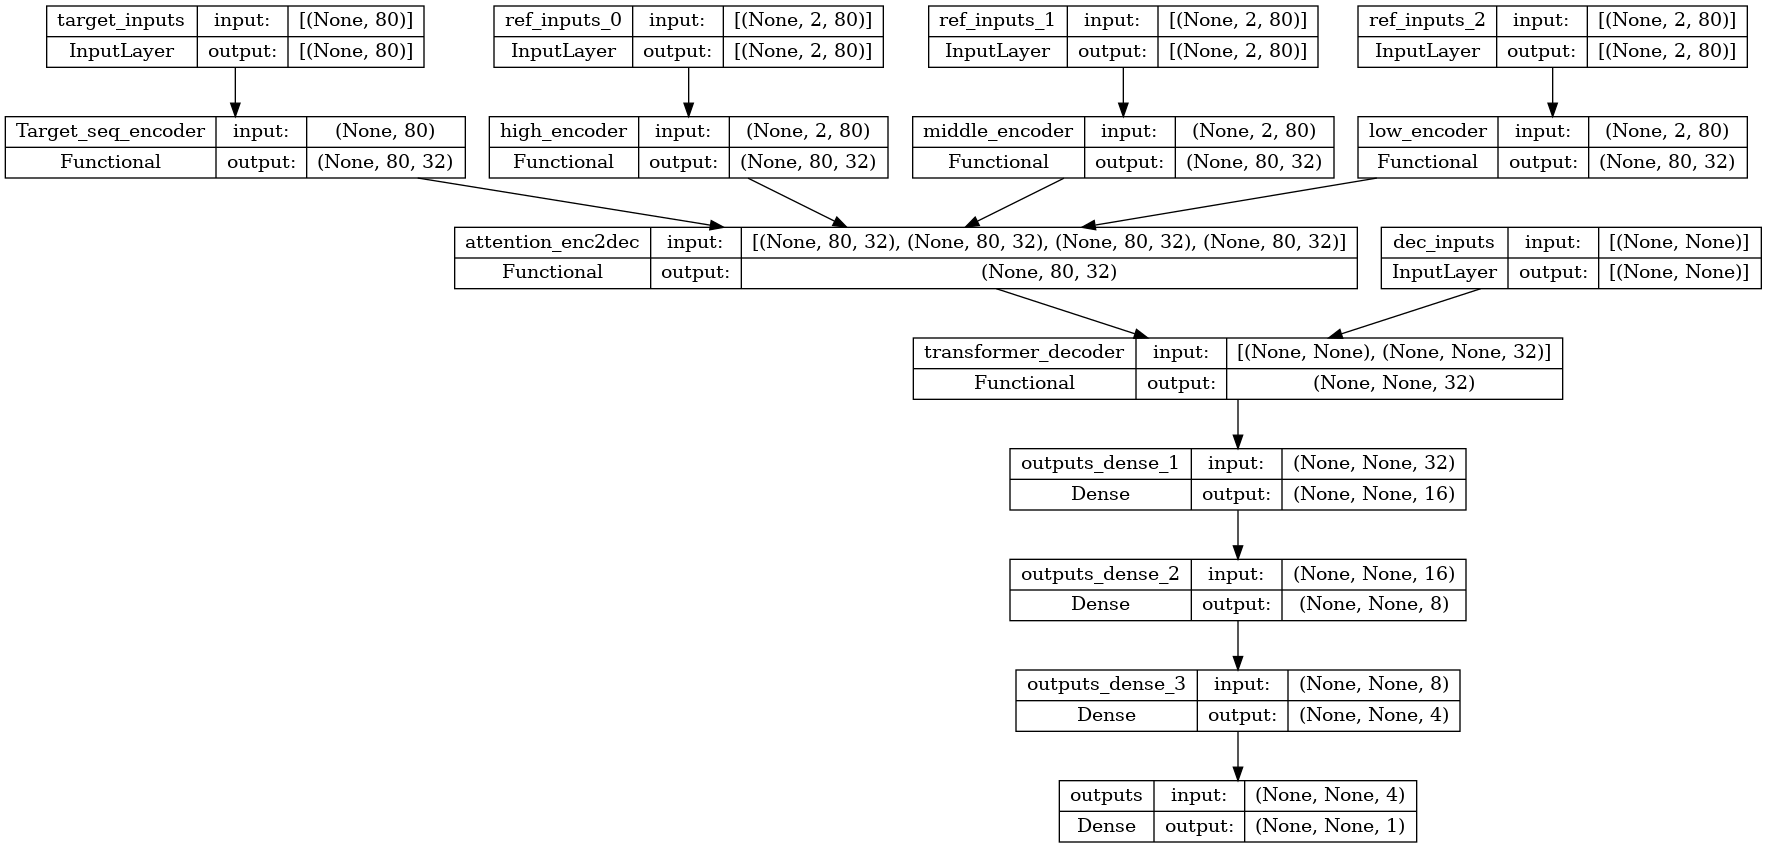

In [31]:
tf.keras.backend.clear_session()

model = MEaI_transformer(
    window_size = params_ETTh1['window_size'],
    forecast_range = params_ETTh1['forecast_range'],
    ref_num_list = [2,2,2],
    num_layers = params_ETTh1['num_layers'],
    dff = params_ETTh1['dff'],
    d_model = params_ETTh1['d_model'],
    num_heads = params_ETTh1['num_heads'],
    dropout = params_ETTh1['dropout'],
    ref_encoder_name=['high_encoder','middle_encoder','low_encoder'],
    name="MEaI_transformer")

tf.keras.utils.plot_model(model, to_file='./imgs/ETTh1_MEaI_transformer.png', show_shapes=True)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss = tf.keras.losses.MeanSquaredError()
             )

In [27]:
callback_path = './result/MEaI_transformer/ETTh1'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/model_ckpt'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    save_weights_only=True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.95 # 10epoch 이후 0.85씩 줄어듦(ex. 0.001, 0.001*0.95, 0.001*0.95^2, 0.001*0.95^3, ...)
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
lr = 0.001
e = np.arange(20)

r = [lr for _ in range(len(e))]
for i in range(20):
    lr_ = lr if i == 0 else r[i-1]
    lr_ = scheduler(i, lr_)
    r[i] = lr_

print(r)
plt.plot(e,r)


In [ ]:
history_kospi = model.fit(train_dataset, epochs=20, validation_data=valid_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

In [ ]:
model.load_weights('./result/MEaI_transformer/ETTh1/ckpt/model_ckpt')

### 결과 예측

In [ ]:
split_by_window_target = []
split_by_window_high = []
split_by_window_middle = []
split_by_window_low = []
label_forecast = []

data_set = test_split.copy()

for i in tqdm(range(data_set.shape[0]-params_ETTh1['window_size']-params_ETTh1['forecast_range']+1)):
    
    split_by_window_target.append(data_set['OT'][i:i+params_ETTh1['window_size']])
    
    split_by_window_high.append(data_set[['HUFL','HULL']][i:i+params_ETTh1['window_size']].T)
    split_by_window_middle.append(data_set[['MUFL','MULL']][i:i+params_ETTh1['window_size']].T)
    split_by_window_low.append(data_set[['LUFL','LULL']][i:i+params_ETTh1['window_size']].T)
    
    label_forecast.append(data_set['OT'][i+params_ETTh1['window_size']-1:i+params_ETTh1['window_size']+params_ETTh1['forecast_range']])
    
split_by_window_target = np.array(split_by_window_target)
split_by_window_high = np.array(split_by_window_high)
split_by_window_middle = np.array(split_by_window_middle)
split_by_window_low = np.array(split_by_window_low)
label_forecast = np.array(label_forecast)
print(f'total process data shape(data, label) : {split_by_window_target.shape},{split_by_window_high.shape},{split_by_window_middle.shape},{split_by_window_low.shape},{label_forecast.shape}')

In [ ]:
label_forecast[:,0,np.newaxis].shape

In [ ]:
fore_ETTh1 = model([split_by_window_target,split_by_window_high,split_by_window_middle,split_by_window_low,label_forecast[:,0,np.newaxis]])
fore_ETTh1.shape

In [ ]:
fore_ETTh1.numpy().reshape((3437,-1))

In [ ]:
forecast_input_dec_1 = np.concatenate([
    label_forecast[:,0,np.newaxis],
    fore_ETTh1.numpy().reshape((3437,-1))
],axis=-1)
forecast_input_dec_1

In [ ]:
for _ in range(47):
    out = model([
        split_by_window_target,
        split_by_window_high,
        split_by_window_middle,
        split_by_window_low,
        forecast_input_dec_1
    ])
    #forecast_input_dec_1 = np.concatenate([test_label[np.newaxis,np.newaxis,1,0],out.numpy().reshape((1,-1))],axis=-1)#concat을 마지막 값만 스택해서?
    forecast_input_dec_1 = np.concatenate([forecast_input_dec_1,out.numpy()[:,-1,0].reshape([3437,1])],axis=-1)#concat을 마지막 값만 스택해서?
print(out)
print(forecast_input_dec_1)

In [ ]:
plt.plot(label_forecast[0,:])
plt.plot(out[0,:])

In [ ]:
mse = np.mean((out.numpy()[:,:].squeeze() - label_forecast[:,1:].squeeze())**2,axis=-1)
np.mean(mse)

In [ ]:
np.mean((out.numpy()[0,:].squeeze() - label_forecast[0,1:].squeeze())**2,axis=-1)


In [ ]:
mae = np.mean(abs(out.numpy()[:,:].squeeze() - label_forecast[:,1:].squeeze()),axis=-1)
np.mean(mae)

In [ ]:
np.mean(abs(out.numpy()[0,:].squeeze() - label_forecast[0,1:].squeeze()),axis=-1)


In [48]:
tf.keras.backend.clear_session()

### 루프(24,48,168,336,720)

In [ ]:
MSE = []
MAE = []

#for FORECAST_RANGE in tqdm([24,48,168,336,720]):
for FORECAST_RANGE in tqdm([720]):
    #config
    params_ETTh1 = {
        'window_size':int(FORECAST_RANGE*1.7),
        'forecast_range':FORECAST_RANGE,
        'num_layers':6,
        'dff':128,
        'd_model':32,
        'num_heads':8,
        'dropout':0.05
    }
    
    #del model
    tf.keras.backend.clear_session()

    model = MEaI_transformer(
            window_size = params_ETTh1['window_size'],
            forecast_range = params_ETTh1['forecast_range'],
            ref_num_list = [2,2,2],
            num_layers = params_ETTh1['num_layers'],
            dff = params_ETTh1['dff'],
            d_model = params_ETTh1['d_model'],
            num_heads = params_ETTh1['num_heads'],
            dropout = params_ETTh1['dropout'],
            ref_encoder_name=['high_encoder','middle_corr_encoder','low_encoder'],
            name=f"MEaI_transformer")
    model.compile(optimizer = tf.keras.optimizers.Nadam(),loss = tf.keras.losses.MeanSquaredError())
    
    #train set
    split_by_window_target = []
    split_by_window_high = []
    split_by_window_middle = []
    split_by_window_low = []
    label_forecast = []
    data_set = train_split.copy()
    for i in range(data_set.shape[0]-params_ETTh1['window_size']-params_ETTh1['forecast_range']+1):
        split_by_window_target.append(data_set['OT'][i:i+params_ETTh1['window_size']])
        split_by_window_high.append(data_set[['HUFL','HULL']][i:i+params_ETTh1['window_size']].T)
        split_by_window_middle.append(data_set[['MUFL','MULL']][i:i+params_ETTh1['window_size']].T)
        split_by_window_low.append(data_set[['LUFL','LULL']][i:i+params_ETTh1['window_size']].T)
        label_forecast.append(data_set['OT'][i+params_ETTh1['window_size']-1:i+params_ETTh1['window_size']+params_ETTh1['forecast_range']])
    split_by_window_target = np.array(split_by_window_target)
    split_by_window_high = np.array(split_by_window_high)
    split_by_window_middle = np.array(split_by_window_middle)
    split_by_window_low = np.array(split_by_window_low)
    label_forecast = np.array(label_forecast)
    BATCH_SIZE = 2
    BUFFER_SIZE = 20000
    train_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'target_inputs': split_by_window_target,
            'ref_inputs_0':split_by_window_high,
            'ref_inputs_1':split_by_window_middle,
            'ref_inputs_2':split_by_window_low,
            'dec_inputs': label_forecast[:,:-1] #teaching force
        },
        {
            'outputs': label_forecast[:, 1:,np.newaxis]
        },
    ))
    train_dataset = train_dataset.cache()
    train_dataset = train_dataset.shuffle(BUFFER_SIZE)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    #validation set
    split_by_window_target = []
    split_by_window_high = []
    split_by_window_middle = []
    split_by_window_low = []
    label_forecast = []
    data_set = valid_split.copy()
    for i in range(data_set.shape[0]-params_ETTh1['window_size']-params_ETTh1['forecast_range']+1):
        split_by_window_target.append(data_set['OT'][i:i+params_ETTh1['window_size']])
        split_by_window_high.append(data_set[['HUFL','HULL']][i:i+params_ETTh1['window_size']].T)
        split_by_window_middle.append(data_set[['MUFL','MULL']][i:i+params_ETTh1['window_size']].T)
        split_by_window_low.append(data_set[['LUFL','LULL']][i:i+params_ETTh1['window_size']].T)
        label_forecast.append(data_set['OT'][i+params_ETTh1['window_size']-1:i+params_ETTh1['window_size']+params_ETTh1['forecast_range']])
    split_by_window_target = np.array(split_by_window_target)
    split_by_window_high = np.array(split_by_window_high)
    split_by_window_middle = np.array(split_by_window_middle)
    split_by_window_low = np.array(split_by_window_low)
    label_forecast = np.array(label_forecast)

    valid_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'target_inputs': split_by_window_target,
            'ref_inputs_0':split_by_window_high,
            'ref_inputs_1':split_by_window_middle,
            'ref_inputs_2':split_by_window_low,
            'dec_inputs': label_forecast[:,:-1] #teaching force
        },
        {
            'outputs': label_forecast[:, 1:,np.newaxis]
        },
    ))
    valid_dataset = valid_dataset.cache()
    valid_dataset = valid_dataset.shuffle(BUFFER_SIZE)
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)    
    
    #callback
    callback_path = f'./result/MEaI_transformer/ETTh1({FORECAST_RANGE})'
    os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
    ckpt_path = callback_path+'/ckpt/model_ckpt'
    callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor='val_loss',
        save_best_only = True,
        save_weights_only=True,
        verbose=0
    )
    os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
    callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')
    callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    #Train
    history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])
    model.load_weights(f'./result/MEaI_transformer/ETTh1({FORECAST_RANGE})/ckpt/model_ckpt')
    
    #test set
    split_by_window_target = []
    split_by_window_high = []
    split_by_window_middle = []
    split_by_window_low = []
    label_forecast = []
    data_set = test_split.copy()
    for i in range(data_set.shape[0]-params_ETTh1['window_size']-params_ETTh1['forecast_range']+1):
        split_by_window_target.append(data_set['OT'][i:i+params_ETTh1['window_size']])
        split_by_window_high.append(data_set[['HUFL','HULL']][i:i+params_ETTh1['window_size']].T)
        split_by_window_middle.append(data_set[['MUFL','MULL']][i:i+params_ETTh1['window_size']].T)
        split_by_window_low.append(data_set[['LUFL','LULL']][i:i+params_ETTh1['window_size']].T)
        label_forecast.append(data_set['OT'][i+params_ETTh1['window_size']-1:i+params_ETTh1['window_size']+params_ETTh1['forecast_range']])
    split_by_window_target = np.array(split_by_window_target)
    split_by_window_high = np.array(split_by_window_high)
    split_by_window_middle = np.array(split_by_window_middle)
    split_by_window_low = np.array(split_by_window_low)
    label_forecast = np.array(label_forecast)
    
    #Forecast
    fore_step = split_by_window_target.shape[0] // 30
    fore_step_mse = []
    fore_step_mae = []
    for i in range(31):
        fore_ETTh1 = model([split_by_window_target[i*fore_step:(i+1)*fore_step,:],
                            split_by_window_high[i*fore_step:(i+1)*fore_step,:],
                            split_by_window_middle[i*fore_step:(i+1)*fore_step,:],
                            split_by_window_low[i*fore_step:(i+1)*fore_step,:],
                            label_forecast[i*fore_step:(i+1)*fore_step,0,np.newaxis]])
        forecast_input_dec_1 = np.concatenate([label_forecast[i*fore_step:(i+1)*fore_step,0,np.newaxis],fore_ETTh1.numpy().reshape((-1,1))],axis=-1)
        for _ in range(FORECAST_RANGE-1):
            out = model([split_by_window_target[i*fore_step:(i+1)*fore_step,:],
                         split_by_window_high[i*fore_step:(i+1)*fore_step,:],
                         split_by_window_middle[i*fore_step:(i+1)*fore_step,:],
                         split_by_window_low[i*fore_step:(i+1)*fore_step,:],
                         forecast_input_dec_1
                        ])
            forecast_input_dec_1 = np.concatenate([forecast_input_dec_1,out.numpy()[:,-1,0].reshape([-1,1])],axis=-1)
        mse = np.mean((out.numpy()[:,:].squeeze() - label_forecast[i*fore_step:(i+1)*fore_step,1:].squeeze())**2,axis=-1)
        mae = np.mean(abs(out.numpy()[:,:].squeeze() - label_forecast[i*fore_step:(i+1)*fore_step,1:].squeeze()),axis=-1)
        fore_step_mse.append(mse)
        fore_step_mae.append(mae)
    fore_step_mse = np.concatenate(fore_step_mse,axis=0)
    fore_step_mae = np.concatenate(fore_step_mae,axis=0)   
    MSE.append(np.mean(fore_step_mse))
    MAE.append(np.mean(fore_step_mae))
MSE = np.array(MSE)
MAE = np.array(MAE)
print(MSE)
print(MAE)

  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

Epoch 1/20
4255/4255 [==============================] - 7531s 2s/step - loss: 0.0199 - val_loss: 0.0069 - lr: 0.0010
Epoch 2/20
4255/4255 [==============================] - 7531s 2s/step - loss: 0.0148 - val_loss: 0.0068 - lr: 0.0010
Epoch 3/20
4255/4255 [==============================] - 7525s 2s/step - loss: 0.0143 - val_loss: 0.0185 - lr: 0.0010
Epoch 4/20
4255/4255 [==============================] - 7519s 2s/step - loss: 0.0134 - val_loss: 0.0171 - lr: 0.0010
Epoch 5/20
4255/4255 [==============================] - 7522s 2s/step - loss: 0.0124 - val_loss: 0.0241 - lr: 0.0010
Epoch 6/20
4255/4255 [==============================] - 7512s 2s/step - loss: 0.0109 - val_loss: 0.0217 - lr: 9.5000e-04
Epoch 7/20
4255/4255 [==============================] - 7525s 2s/step - loss: 0.0093 - val_loss: 0.0201 - lr: 9.0250e-04
Epoch 8/20
4255/4255 [==============================] - 7540s 2s/step - loss: 0.0083 - val_loss: 0.0219 - lr: 8.5737e-04
Epoch 9/20
4255/4255 [==============================

In [51]:
print(MSE)
print(MAE)

[0.1402830100292082]
[0.2995852465627529]


```python
print(MSE)
[0.07515048614661463, 0.14425535643768017, 0.11603953209086278, 0.1402830100292082]
print(MAE)
[0.21208309424960112, 0.28995917921412095, 0.267602527298358  , 0.2995852465627529]
```

In [32]:
    fore_ETTh1 = model([split_by_window_target,split_by_window_high,split_by_window_middle,split_by_window_low,label_forecast[:,0,np.newaxis]])
    forecast_input_dec_1 = np.concatenate([label_forecast[:,0,np.newaxis],fore_ETTh1.numpy().reshape((-1,1))],axis=-1)
    for _ in range(FORECAST_RANGE-1):
        out = model([
                     split_by_window_target,
                     split_by_window_high,
                     split_by_window_middle,
                     split_by_window_low,
                     forecast_input_dec_1
                    ])
        forecast_input_dec_1 = np.concatenate([forecast_input_dec_1,out.numpy()[:,-1,0].reshape([-1,1])],axis=-1)
        
    mse = np.mean((out.numpy()[:,:].squeeze() - label_forecast[:,1:].squeeze())**2,axis=-1)
    MSE.append(np.mean(mse))
    mae = np.mean(abs(out.numpy()[:,:].squeeze() - label_forecast[:,1:].squeeze()),axis=-1)
    MAE.append(np.mean(mae))

3112

In [37]:
split_by_window_target[3110:311*11,:].shape

(2, 285)

In [39]:
#Forecast
#일단 되면 30개로 나누자!
fore_step = split_by_window_target.shape[0] // 30

fore_step_mse = []
fore_step_mae = []
for i in range(31):
    fore_ETTh1 = model([split_by_window_target[i*fore_step:(i+1)*fore_step,:],
                        split_by_window_high[i*fore_step:(i+1)*fore_step,:],
                        split_by_window_middle[i*fore_step:(i+1)*fore_step,:],
                        split_by_window_low[i*fore_step:(i+1)*fore_step,:],
                        label_forecast[i*fore_step:(i+1)*fore_step,0,np.newaxis]])
    forecast_input_dec_1 = np.concatenate([label_forecast[i*fore_step:(i+1)*fore_step,0,np.newaxis],fore_ETTh1.numpy().reshape((-1,1))],axis=-1)
    for _ in range(FORECAST_RANGE-1):
        out = model([
                     split_by_window_target[i*fore_step:(i+1)*fore_step,:],
                     split_by_window_high[i*fore_step:(i+1)*fore_step,:],
                     split_by_window_middle[i*fore_step:(i+1)*fore_step,:],
                     split_by_window_low[i*fore_step:(i+1)*fore_step,:],
                     forecast_input_dec_1
                    ])
        forecast_input_dec_1 = np.concatenate([forecast_input_dec_1,out.numpy()[:,-1,0].reshape([-1,1])],axis=-1)
    mse = np.mean((out.numpy()[:,:].squeeze() - label_forecast[i*fore_step:(i+1)*fore_step,1:].squeeze())**2,axis=-1)
    mae = np.mean(abs(out.numpy()[:,:].squeeze() - label_forecast[i*fore_step:(i+1)*fore_step,1:].squeeze()),axis=-1)
    fore_step_mse.append(mse)
    fore_step_mae.append(mae)
fore_step_mse = np.concatenate(fore_step_mse,axis=0)
fore_step_mae = np.concatenate(fore_step_mae,axis=0)
print(fore_step_mse.shape,fore_step_mae.shape)
MSE.append(np.mean(fore_step_mse))
MAE.append(np.mean(fore_step_mae))
print(MSE,MAE)

(3112,) (3112,)
[0.04551527303309174] [0.15398117254306481]


In [44]:
np.mean(fore_step_mse)

0.11603953209086278

In [45]:
np.mean(fore_step_mae)

0.267602527298358